# Distinguishing muffins and Chihuahuas with NNs

The aim of this project is to train a neural network for the binary classification of muffins and Chihuahuas based on the images contained in the relative [Kaggle dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

# Setup

In [1]:
import importlib
import pip

def import_or_install(package_name, alias=None):
    try:
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing...")
        pip.install(package_name)
        if alias:
            globals()[alias] = importlib.import_module(package_name)
        print(f"{package_name} has been installed.")

c:\Users\lucia\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


We import the dataset from Kaggle, using a token.

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

import_or_install("kaggle")

from kaggle.api.kaggle_api_extended import KaggleApi

FOLDERNAME = "muffin-vs-chihuahua-image-classification"
PATH = "./"

api = KaggleApi()
api.authenticate()
api.dataset_download_files("samuelcortinhas/muffin-vs-chihuahua-image-classification", PATH)

In [3]:
import zipfile

with zipfile.ZipFile(PATH + FOLDERNAME + ".zip", 'r') as zip_ref:
    zip_ref.extractall(FOLDERNAME)
os.remove(PATH + FOLDERNAME +".zip")

If already present we import, or otherwise we install, the `tensorflow`package. Above all functionalities we will be using the `keras` module to construct the desired neural network for this project.

In [4]:
import_or_install("tensorflow","tf")

c:\Users\lucia\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



tensorflow is already installed.


Before proceeding we remove badly encoded images.

In [5]:
from PIL import Image
def remove_badly_encoded_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.JPG'):
            try:
                img = Image.open(directory+filename)  # open the image file
                img.verify()  # verify that it is, in fact an image
                img.close()
            except (IOError, SyntaxError):
                os.remove(directory+filename)

deleted = remove_badly_encoded_images(PATH + FOLDERNAME + "/")
print("Deleted images:",deleted)

Deleted images: None


We begin by subdividing the dataset into training and test set. This partition is provided by the Kaggle dataset itself, with $\frac{1}{5}$ of the images assigned to the test set. 

We also infer the binary labels from the layout of the dataset. Specifically the labels are assigned as follows:
\begin{equation*}
    \begin{cases}
        0  & \text{chihuahua} \\
        1  & \text{muffin}
    \end{cases}
\end{equation*}

In [6]:
def create_dataset(foldername):
    train_path = os.path.join(PATH, FOLDERNAME, foldername)
    return tf.keras.utils.image_dataset_from_directory(train_path, labels = "inferred")

print("Training set:")
train_ds = create_dataset("train")
print("Test set")
test_ds = create_dataset("test")
   

Training set:
Found 4733 files belonging to 2 classes.
Test set
Found 1184 files belonging to 2 classes.


Let's give a look at a small sample of pictures with the relative annotations.

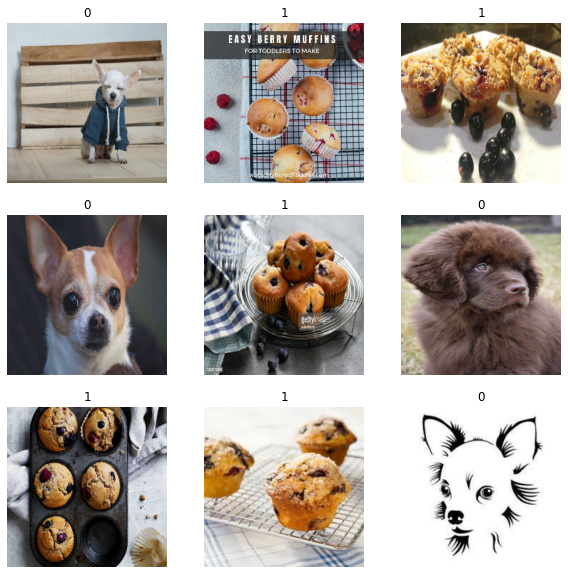

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Before diving into the experiments we prepare a function that produces variations of the images in the dataset. We have chosen to 
This data augmentation step is useful to make a small dataset more expressive, so counteracting overfitting.

In [16]:
from keras import layers

def data_augmentation(images, data_augmentation_layers):
    for layer in data_augmentation_layers:
        images = layer(images, training = True)
    return images

For example we may randomly flip the picture or slightly tilt it.

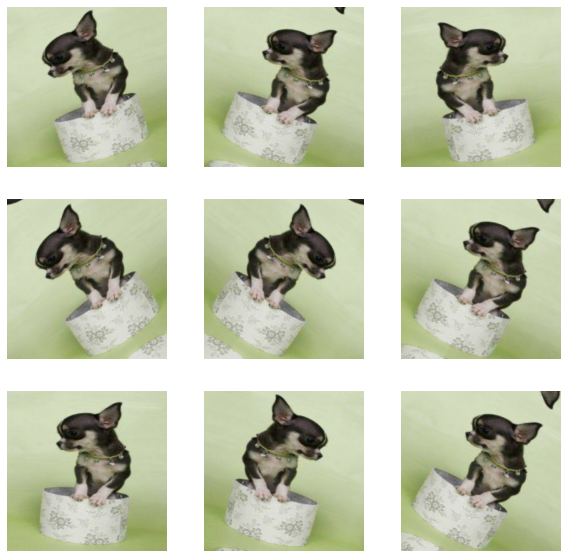

In [17]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, data_augmentation_layers)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")